# **基于深度学习的医学影像检测（肺炎）**

## 一、 **环境搭建**

深度学习框架、图像处理、数据处理、数据可视化和模型评估等。（都装好了就不要重复执行了）


pip install tensorflow opencv-python pillow numpy pandas matplotlib seaborn scikit-learn jupyter

## 二、 **数据集准备**


### **2.1 数据集已经放在文件夹中，下面检索数据。观察数据的分布。**

训练集 - 正常: 1341, 肺炎: 3875


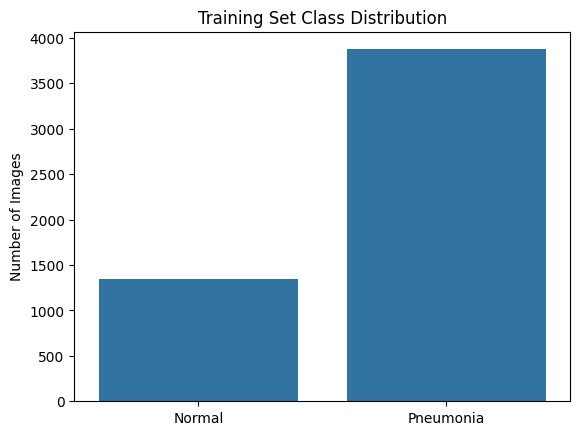

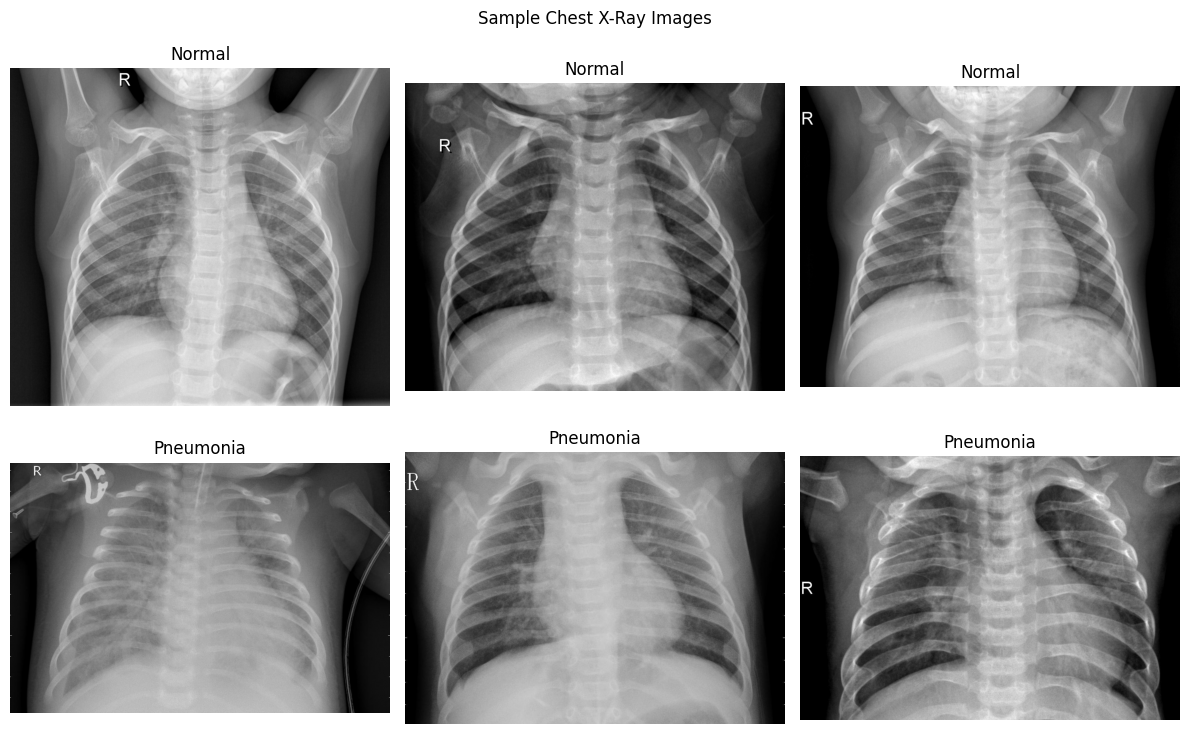

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 查看数据在文件夹中的分布
train_normal_dir = 'chest_xray/train/NORMAL'
train_pneu_dir = 'chest_xray/train/PNEUMONIA'

num_normal = len(os.listdir(train_normal_dir))
num_pneu = len(os.listdir(train_pneu_dir))

print(f"训练集 - 正常: {num_normal}, 肺炎: {num_pneu}")

# 绘制类别分布图
sns.barplot(x=['Normal', 'Pneumonia'], y=[num_normal, num_pneu])
plt.title('Training Set Class Distribution')
plt.ylabel('Number of Images')
plt.show()

# 2. 可视化一些样本图像
def plot_sample_images():
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle('Sample Chest X-Ray Images')

    # 显示正常图像
    normal_imgs = os.listdir(train_normal_dir)[:3]
    for i, img_name in enumerate(normal_imgs):
        img_path = os.path.join(train_normal_dir, img_name)
        img = plt.imread(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title('Normal')
        axes[0, i].axis('off')

    # 显示肺炎图像
    pneu_imgs = os.listdir(train_pneu_dir)[:3]
    for i, img_name in enumerate(pneu_imgs):
        img_path = os.path.join(train_pneu_dir, img_name)
        img = plt.imread(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title('Pneumonia')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images()

### **2.2 数据预处理及增强**

将图像调整统一尺寸为224x224像素。

像素值归一化

对训练集进行数据增强。防止过拟合。

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 定义图像尺寸和批次大小
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# 训练集数据增强生成器
train_datagen = ImageDataGenerator(
    rescale=1./255,       # 归一化
    rotation_range=20,     # 随机旋转角度
    width_shift_range=0.2, # 随机水平平移
    height_shift_range=0.2, # 随机垂直平移
    shear_range=0.2,       # 随机错切变换
    zoom_range=0.2,        # 随机缩放
    horizontal_flip=True,  # 随机水平翻转
    fill_mode='nearest'    # 填充新像素的策略
)

# 验证集和测试集 ONLY rescaling (不进行增强!)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 创建数据生成器
train_generator = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary', # 二分类问题
    color_mode='rgb'     # 即使原图是灰度，也转为3通道以适配预训练模型
)

validation_generator = val_test_datagen.flow_from_directory(
    'chest_xray/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False # 验证集不需要打乱
)

test_generator = val_test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False # 测试集不需要打乱
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## **二、 模型实现**

### **2.1、加载预训练模型并构建新模型**

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# 加载预训练的VGG16模型，不包括顶部分类层
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 冻结预训练模型的权重，初始阶段不训练它们
base_model.trainable = False

# 在预训练模型之上构建新模型
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # 替代Flatten，减少参数，防止过拟合
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout层，随机丢弃50%的神经元，防止过拟合
    Dense(1, activation='sigmoid') # 二分类输出层
])

# 编译模型
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 查看模型结构
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

**代码解释：**

在初始训练完成后，可以解冻基础模型的部分高层，以更低的学习率训练，以适应新任务。

In [5]:
# 解冻基础模型的最后4层
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# 使用更小的学习率重新编译
model.compile(
    optimizer=Adam(learning_rate=1e-5), # 学习率是初始的1/10
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## **三、模型训练与评估**

### **3.1 训练模型**


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 定义回调函数
# 保存最佳模型
checkpoint = ModelCheckpoint('best_pneumonia_model.h5',
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max',
                            verbose=1)
# 早停，防止过拟合
earlystop = EarlyStopping(monitor='val_loss',
                          patience=5, # 如果5个epoch后验证损失不再下降，则停止训练
                          restore_best_weights=True,
                          verbose=1)

callbacks = [checkpoint, earlystop]

# 计算类别权重，以处理数据不平衡问题
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 获取训练集的标签
train_labels = train_generator.classes
# 计算类别权重
class_weights = compute_class_weight('balanced',
                                    classes=np.unique(train_labels),
                                    y=train_labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# 开始训练
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30, # 可以设置一个较大的值，由早停回调来控制实际停止时机
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weight_dict # 应用类别权重
)

Class Weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


C:\Users\lmy18\.conda\envs\Med\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5535 - loss: 0.6392   
Epoch 1: val_accuracy improved from None to 0.75000, saving model to best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 863s 5s/step - accuracy: 0.7281 - loss: 0.4692 - val_accuracy: 0.7500 - val_loss: 0.4762
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9026 - loss: 0.2388   
Epoch 2: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 854s 5s/step - accuracy: 0.9062 - loss: 0.2279 - val_accuracy: 0.7500 - val_loss: 0.3936
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9291 - loss: 0.1953   
Epoch 3: val_accuracy improved from 0.75000 to 0.93750, saving model to best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 854s 5s/step - accuracy: 0.9308 - loss: 0.1806 - val_accuracy: 0.9375 - val_loss: 0.3116
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9355 - loss: 0.1639   
Epoch 4: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 854s 5s/step - accuracy: 0.9421 - loss: 0.1513 - val_accuracy: 0.9375 - val_loss: 0.2733
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9425 - loss: 0.1500   
Epoch 5: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 854s 5s/step - accuracy: 0.9467 - loss: 0.1478 - val_accuracy: 0.8750 - val_loss: 0.2505
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9490 - loss: 0.1344   
Epoch 6: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 855s 5s/step - accuracy: 0.9494 - loss: 0.1361 - val_accuracy: 0.8750 - val_loss: 0.2463
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9572 - loss: 0.1167   
Epoch 7: val_accuracy d

### **3.2 评估模型**


20/20 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.8494 - loss: 0.3134 
Test Loss: 0.3134
Test Accuracy: 0.8494
20/20 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step 


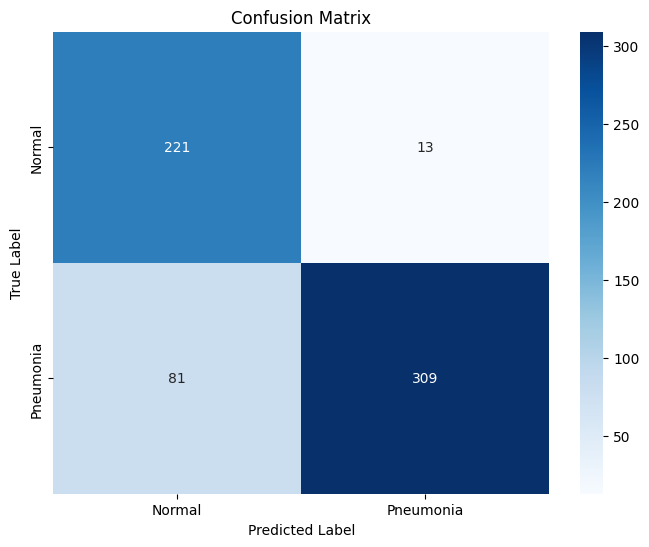

              precision    recall  f1-score   support

      Normal       0.73      0.94      0.82       234
   Pneumonia       0.96      0.79      0.87       390

    accuracy                           0.85       624
   macro avg       0.85      0.87      0.85       624
weighted avg       0.87      0.85      0.85       624



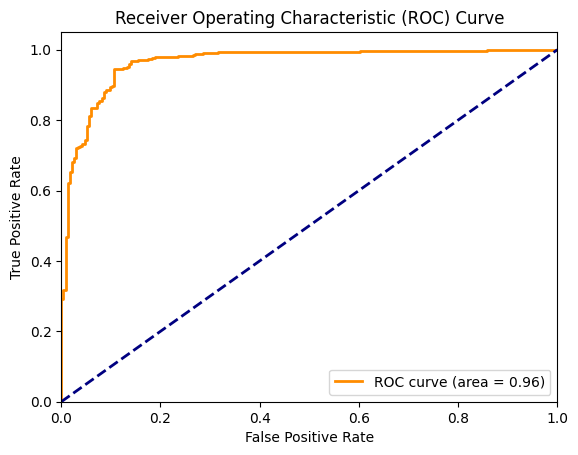

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 加载最佳模型 
from tensorflow.keras.models import load_model
best_model = load_model('best_pneumonia_model.h5')

# 2. 在测试集上进行最终评估
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 3. 进行预测
test_predictions = best_model.predict(test_generator)
test_pred_classes = (test_predictions > 0.5).astype("int32") # 将概率转换为类别 (0 or 1)

# 获取真实标签
true_classes = test_generator.classes

# 4. 生成并绘制混淆矩阵
cm = confusion_matrix(true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5. 打印详细的分类报告
print(classification_report(true_classes, test_pred_classes,
                            target_names=['Normal', 'Pneumonia']))

# 6. 绘制ROC曲线
fpr, tpr, thresholds = roc_curve(true_classes, test_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


诊断脚本

In [7]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)  # 打印设备分配日志
print("TensorFlow版本:", tf.__version__)
print("GPU列表:", tf.config.list_physical_devices('GPU'))

# 尝试在GPU上执行简单运算
a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
c = a + b
print(c)

TensorFlow版本: 2.20.0
GPU列表: []
tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)


## **四、结果分析与可视化**

### **4.1、绘制训练历史**

分析：观察曲线是否收敛，是否有过拟合（训练准确率持续上升但验证准确率停滞或下降）或欠拟合（两者都较低）的迹象。

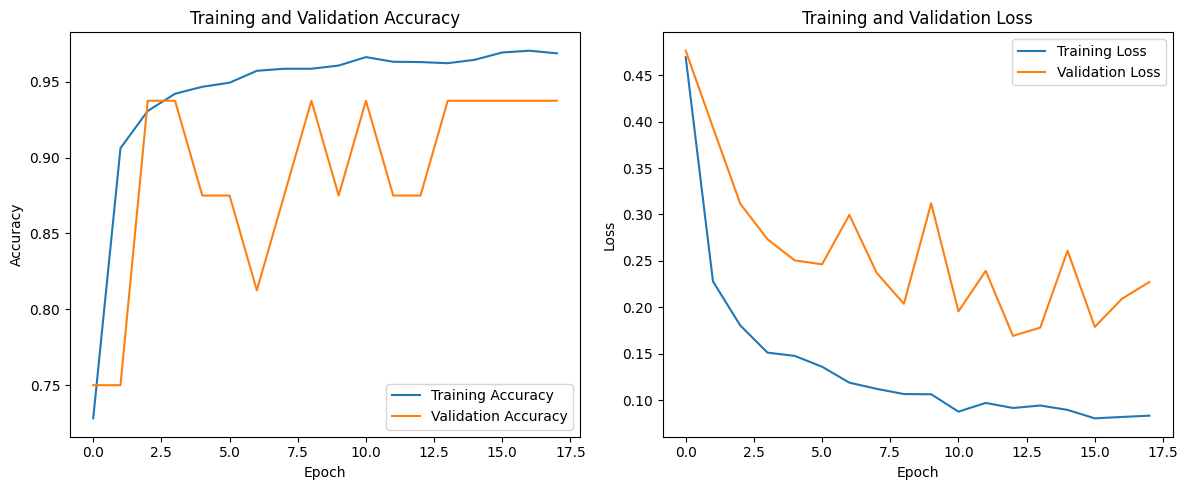

In [9]:
# 绘制训练和验证的准确率曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 绘制训练和验证的损失曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**图形化界面检测**

In [1]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# 加载训练好的模型
model = tf.keras.models.load_model('best_pneumonia_model.h5')

def predict_pneumonia(image):
    # 预处理图像
    image = image.resize((224, 224))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    
    # 预测
    prediction = model.predict(image_array)[0][0]
    result = "肺炎" if prediction > 0.5 else "正常"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return f"{result} (置信度: {confidence:.2%})"

# 创建界面
iface = gr.Interface(
    fn=predict_pneumonia,
    inputs=gr.Image(type="pil", label="上传胸部X光片"),
    outputs="text",
    title="肺炎自动识别系统",
    description="上传胸部X光图像，AI将自动识别是否患有肺炎"
)

iface.launch()

C:\Users\lmy18\.conda\envs\Med\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


## **五、总结**